<a href="https://colab.research.google.com/github/SerraTalas/DeepLearningProject/blob/main/YSA_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing  Libraries
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(101)#grafiklerin hüce içinde görünmesini sağlar

In [ ]:
from google.colab import files

files.upload()  # 'kaggle.json' dosyası yüklenir

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"serratalas","key":"0d5506ae3cc9364b503ff9c162d96546"}'}

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

In [ ]:
!mkdir ~/.kaggle  # Kaggle dizini oluşturulur
!cp kaggle.json ~/.kaggle/  # API anahtarı taşınır
!chmod 600 ~/.kaggle/kaggle.json  # Dosyaya uygun izinler verilir

In [ ]:
! unzip histopathologic-cancer-detection.zip -d histopathologic-cancer-detection

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: histopathologic-cancer-detection/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: histopathologic-cancer-detection/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: histopathologic-cancer-detection/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: histopathologic-cancer-detection/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: histopathologic-cancer-detection/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: histopathologic-cancer-detection/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: histopathologic-cancer-detection/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: histopathologic-cancer-detection/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: histopathologic-cancer-detection/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: histopathologic-cancer-detection/train/fa2e6db0b3

In [ ]:
IMAGE_SIZE=96 # görüntülerin boyutu 96x96 piksel
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000 # her label'da 80000 örnek eğitilecek

In [ ]:
# So, what are the files which are available?

os.listdir('/content/histopathologic-cancer-detection')

['train_labels.csv', 'sample_submission.csv', 'test', 'train']

In [ ]:
print(len(os.listdir('/content/histopathologic-cancer-detection/train')))
print(len(os.listdir('/content/histopathologic-cancer-detection/test')))

220025
57458


In [ ]:
# csv dosyalarının okunması

df_data = pd.read_csv('/content/histopathologic-cancer-detection/train_labels.csv')

# eğitimde hata veren görüntü silinir
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# siyah görüntü silinir
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [ ]:
df_data['label'].value_counts() # eğitim setindeki 1 ve 0 etiketleri


0    130908
1     89117
Name: label, dtype: int64

In [ ]:
# eşit sayıda 0 ve 1 etiketleri karıştırılarak alınır
df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

# 0 ve 1 kümelerini birleştirir
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df_data = shuffle(df_data) # sıralı eğitilmemesi ve eğitimin daha verimli olması için

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [ ]:
# Eğitim ve validation setlerinin oluşturulması
# validation modelin eğitim verileri üzerindeki performansını değerlendirmek için kullanılır
# genelleme yapma yeteneği değerlendirilir
y = df_data['label']
#kullanılan veri seti
#veri setinin %10'u doğrulama için ayrılır
#rastgele bölme işleminin her denemede aynı kalmasını sağlar, böylece denemeler arası tutuarlılık oluşturulur.
#0 ve 1 etiketlerini iki veri seti için de orantılı dağıtır
df_train, df_val = train_test_split(df_data, test_size=0.10,
                                    random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [ ]:
# base_dir adlı dosya oluşturulur.
base_dir='base_dir'
os.mkdir(base_dir)

# base_dir dosyasının altında train ve validation dosyaları oluşturulur.
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

#train ve validation klasörlerinin içinde her sınıf için ayrı klasörler oluşturulur.
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [ ]:
# Oluşturulan dosyalar kontrol edilir.
os.listdir('base_dir/train_dir')

['b_has_tumor_tissue', 'a_no_tumor_tissue']

In [ ]:
#Satırlara hızlı şekilde erişmek için
df_data.set_index('id', inplace=True)

In [ ]:
#train ve val görüntüleri listelere eklenir.
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Train görüntüleri train_dir dosyasına transfer edilir.

for image in train_list:

    # csv dosyalarındaki id'ye .tif uzantısı eklenir.
    fname = image + '.tif'
    # Görüntülerin etiket değerleri alınır.
    target = df_data.loc[image,'label']

    # label değerleri atanır.
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'

    # Görüntünün kaynak dosyası
    src = os.path.join('/content/histopathologic-cancer-detection/train', fname)
    # Görüntünün hedef dosyası
    dst = os.path.join(train_dir, label, fname)
    # Kaynaktan hedefe görüntü kopyalanır.
    shutil.copyfile(src, dst)


# Validation görüntüleri val_dir dosyasına transfer edilir.

for image in val_list:

    # csv dosyalarındaki id'ye .tif uzantısı eklenir.
    fname = image + '.tif'
    # Görüntülerin etiket değerleri alınır.
    target = df_data.loc[image,'label']

    # label değerleri atanır.
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'

    # Görüntünün kaynak dosyası
    src = os.path.join('/content/histopathologic-cancer-detection/train', fname)
    # Görüntünün hedef dosyası
    dst = os.path.join(val_dir, label, fname)
    # Kaynaktan hedefe görüntü kopyalanır.
    shutil.copyfile(src, dst)

In [ ]:
# train_dir dosyasındaki alt klasörler kontrol edilir.

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

72000
72000


In [ ]:
# val_dir dosyasındaki alt klasörler kontrol edilir.

print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))

8000
8000


In [ ]:
# Dosya yolları ve batch boyutları belirlenir.
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '/content/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 15 #bir eğitim adımında kullanılan örnek sayısı
val_batch_size = 15

#np.ceil ile bir üst sayıya yuvarlama yapılır.
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
#görüntü normalleştirmek için
datagen = ImageDataGenerator(rescale=1.0/255)

# train seti için verileri arttırma
train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')
# validation seti için verileri arttırma
val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# modelin performansını arttırmak için test verileri karıştırılmaz.
#batch boyutu 1 çünkü her bir görüntünün ayrı ayrı değerlendirilmesi gerekir.
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
#evrişimli katmanlarda kullanılacak filtre (kernel) boyutunu belirtir
kernel_size = (3,3)
#max pooling katmanlarında kullanılacak havuzlama penceresinin boyutunu belirtir
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
#Evrişimli katmanlarda belirli bir olasılıkla rastgele seçilen nöronlar devre dışı bırakılır.
dropout_conv = 0.3
#Tam bağlantılı (dense) katmanlarda dropout
dropout_dense = 0.3

#Bir model oluşturulur, katmanları sıralı bir şekilde bir araya getirmek için kullanılır.
model = Sequential()

#İlk üç satır, ilk evrişimli katman grubunu oluşturur.
#first_filters kadar filtre kullanır ve her biri kernel_size boyutundadır. Her evrişimli katmanın ardından ReLU aktivasyon fonksiyonu uygulanmıştır.
#Dördüncü satır, maksimum havuzlama katmanını ekler.
#Bu katman, evrişimli katmanların özellik haritalarını küçültmek için kullanılır.
#Beşinci satır, evrişimli katmanlardan sonra dropout uygular, aşırı uyarlanma riskini azaltmaya yardımcı olur.
model.add(Conv2D(first_filters, kernel_size, activation='relu',
                 input_shape=(96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())

#Tam bağlantılı (dense) katmanlar eklenir.
#Öğrenilen özellikleri kullanarak sınıflandırma yapar.
#Modelin çıkış katmanında iki nöron vardır (2 sınıf için)
#Softmax aktivasyon fonksiyonu kullanılarak sınıflandırma yapılır.
model.add(Dense(512, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation='softmax'))

#Modelin mimarisini ve parametre sayılarını gösteren bir özet oluşturur.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 45, 45, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 43, 43, 64)        18496     
                                                      

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [ ]:
#modelin kaydedileceği dosya
filepath = "model.h5"

#modelin performansına göre yalnızca en iyi modeli kaydetmek için kullanılır
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

#modelin performansına göre öğrenme oranını dinamik olarak ayarlamak için kullanılır.
#öğrenme oranının yarıya indirilerek ilerler.
#patience performansta bir iyileşme gözlenmediğinde kaç epoch boyunca bekleyeceğini belirtir.
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.0001)

#kullanılacak geri çağrıları içerir
callbacks_list = [checkpoint, reduce_lr]

#fit fonksiyonu, modeli eğitmek için kullanılır.
#her bir epoch için eğitim ve doğrulama adımlarının sayısını belirlenir.
#her veri 20 defa modelden geçirilir.
history = model.fit(train_gen, steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
9598/9600 [============================>.] - ETA: 0s - loss: 0.2425 - accuracy: 0.9032

9600/9600 [==============================] - 267s 28ms/step - loss: 0.2425 - accuracy: 0.9032 - val_loss: 0.2181 - val_accuracy: 0.9149 - lr: 1.0000e-04
Epoch 2/20
9600/9600 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9090

9600/9600 [==============================] - 264s 28ms/step - loss: 0.2307 - accuracy: 0.9090 - val_loss: 0.2535 - val_accuracy: 0.8961 - lr: 1.0000e-04
Epoch 3/20
9600/9600 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9131

9600/9600 [==============================] - 269s 28ms/step - loss: 0.2225 - accuracy: 0.9131 - val_loss: 0.2224 - val_accuracy: 0.9127 - lr: 1.0000e-04
Epoch 4/20
9598/9600 [============================>.] - ETA: 0s - loss: 0.2138 - accuracy: 0.9166

9600/9600 [==============================] - 263s 27ms/step - loss: 0.2137 - accuracy: 0.9166 - val_loss: 0.2116 - val_accuracy: 0.9175 - lr: 1.0000e-04
Epoch 5/20
9598/9600 [============================>.] - ETA: 0s - loss: 0.2082 - accuracy: 0.9189

9600/9600 [==============================] - 264s 28ms/step - loss: 0.2082 - accuracy: 0.9189 - val_loss: 0.2650 - val_accuracy: 0.8963 - lr: 1.0000e-04
Epoch 6/20
9599/9600 [============================>.] - ETA: 0s - loss: 0.2027 - accuracy: 0.9222

9600/9600 [==============================] - 265s 28ms/step - loss: 0.2027 - accuracy: 0.9222 - val_loss: 0.2222 - val_accuracy: 0.9060 - lr: 1.0000e-04
Epoch 7/20
9598/9600 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9242

9600/9600 [==============================] - 264s 28ms/step - loss: 0.1947 - accuracy: 0.9242 - val_loss: 0.1824 - val_accuracy: 0.9312 - lr: 1.0000e-04
Epoch 8/20
9598/9600 [============================>.] - ETA: 0s - loss: 0.1908 - accuracy: 0.9267

9600/9600 [==============================] - 269s 28ms/step - loss: 0.1908 - accuracy: 0.9267 - val_loss: 0.1918 - val_accuracy: 0.9287 - lr: 1.0000e-04
Epoch 9/20
9600/9600 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9297

9600/9600 [==============================] - 268s 28ms/step - loss: 0.1841 - accuracy: 0.9297 - val_loss: 0.1913 - val_accuracy: 0.9283 - lr: 1.0000e-04
Epoch 10/20
9599/9600 [============================>.] - ETA: 0s - loss: 0.1809 - accuracy: 0.9303

9600/9600 [==============================] - 265s 28ms/step - loss: 0.1809 - accuracy: 0.9303 - val_loss: 0.1912 - val_accuracy: 0.9267 - lr: 1.0000e-04
Epoch 11/20
9598/9600 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9335

9600/9600 [==============================] - 268s 28ms/step - loss: 0.1749 - accuracy: 0.9335 - val_loss: 0.2009 - val_accuracy: 0.9189 - lr: 1.0000e-04
Epoch 12/20
9599/9600 [============================>.] - ETA: 0s - loss: 0.1731 - accuracy: 0.9349

9600/9600 [==============================] - 269s 28ms/step - loss: 0.1731 - accuracy: 0.9349 - val_loss: 0.1653 - val_accuracy: 0.9371 - lr: 1.0000e-04
Epoch 13/20
9599/9600 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9353

9600/9600 [==============================] - 262s 27ms/step - loss: 0.1685 - accuracy: 0.9353 - val_loss: 0.1791 - val_accuracy: 0.9316 - lr: 1.0000e-04
Epoch 14/20
9600/9600 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9383

9600/9600 [==============================] - 270s 28ms/step - loss: 0.1641 - accuracy: 0.9383 - val_loss: 0.1925 - val_accuracy: 0.9211 - lr: 1.0000e-04
Epoch 15/20
9600/9600 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9390

9600/9600 [==============================] - 261s 27ms/step - loss: 0.1629 - accuracy: 0.9390 - val_loss: 0.1704 - val_accuracy: 0.9312 - lr: 1.0000e-04
Epoch 16/20
9600/9600 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9403

9600/9600 [==============================] - 267s 28ms/step - loss: 0.1572 - accuracy: 0.9403 - val_loss: 0.1737 - val_accuracy: 0.9344 - lr: 1.0000e-04
Epoch 17/20
9600/9600 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9417

9600/9600 [==============================] - 269s 28ms/step - loss: 0.1535 - accuracy: 0.9417 - val_loss: 0.1902 - val_accuracy: 0.9266 - lr: 1.0000e-04
Epoch 18/20
9599/9600 [============================>.] - ETA: 0s - loss: 0.1522 - accuracy: 0.9431

9600/9600 [==============================] - 260s 27ms/step - loss: 0.1522 - accuracy: 0.9431 - val_loss: 0.1672 - val_accuracy: 0.9357 - lr: 1.0000e-04
Epoch 19/20
9598/9600 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9442

9600/9600 [==============================] - 261s 27ms/step - loss: 0.1499 - accuracy: 0.9442 - val_loss: 0.1593 - val_accuracy: 0.9386 - lr: 1.0000e-04
Epoch 20/20
9599/9600 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9450

9600/9600 [==============================] - 264s 28ms/step - loss: 0.1461 - accuracy: 0.9450 - val_loss: 0.1626 - val_accuracy: 0.9408 - lr: 1.0000e-04


In [ ]:
#eğitilmiş bir modelin validation seti üzerindeki performansını değerlendirir.

val_loss, val_acc = \
model.evaluate_generator(test_gen,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

16000/16000 [==============================] - 68s 4ms/step - loss: 0.1626 - accuracy: 0.9408
val_loss: 0.16262179613113403
val_acc: 0.9408125281333923


<Figure size 640x480 with 0 Axes>

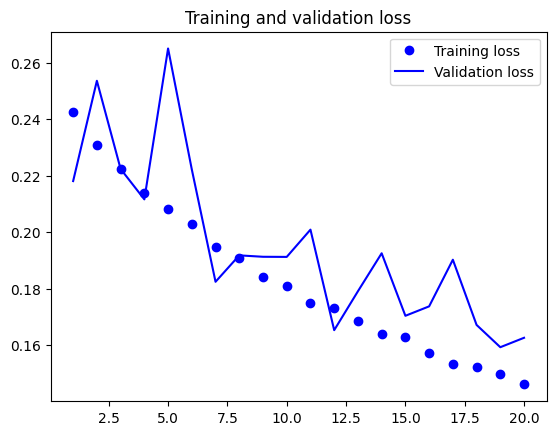

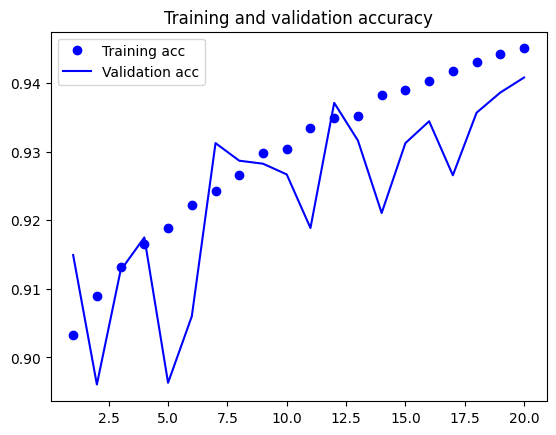

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

#eğitim süreci sırasında toplanan metrik değerlerini çeker.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#toplam epoch sayısı boyunca artan bir dizi sayı içerir.
epochs = range(1, len(acc) + 1)

#eğitim ve doğrulama kayıp değerlerini gösterir.
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

# eğitim ve doğrulama doğruluk değerlerini gösterir.
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Disk alanı serbest bırakmak için base_dir ve alt klasörleri silinir.

shutil.rmtree('base_dir')
#test_dir klasörü oluşturulur

# Test resimlerini bir klasörden predict_generator() fonksiyonuna ileteceğiz.
# Keras, yolun resimleri değil, resimleri içeren bir klasöre işaret etmesini ister.
# Bu yüzden bir klasör (test_images) oluşturuyoruz ve başka bir klasörün (test_dir) içine koyuyoruz.

# test_dir
    # test_images

# test_dir'u oluştur
test_dir = 'test_dir'
os.mkdir(test_dir)

# test_dir içinde test_images klasörü oluşturulur
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
# Oluşturduğumuz dizinin varlığı kontrol edilir
os.listdir('test_dir')

['test_images']

In [ ]:
# test görüntüleri image_dir dosyasına transfer edilir.

test_list = os.listdir('/content/histopathologic-cancer-detection/test')

for image in test_list:

    fname = image

    # görüntünün kaynak dosyası
    src = os.path.join('/content/histopathologic-cancer-detection/test', fname)
    # görüntünün hedef dosyası
    dst = os.path.join(test_images, fname)
    # görüntü kaynaktan hedefe taşınır
    shutil.copyfile(src, dst)

len(os.listdir('test_dir/test_images'))

57458

In [ ]:
test_path ='test_dir'


# Burada, yolun test_images klasörüne işaret edilmesi sağlanır.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [ ]:
num_test_images = 57458

# model.predict() fonksiyonu, belirtilen sayıda adımda (steps) test_gen üzerinde tahmin yapar.
# Tahminler, 'predictions' değişkenine atanır.
predictions = model.predict(test_gen, steps=num_test_images, verbose=1)

57458/57458 [==============================] - 197s 3ms/step


In [ ]:
#Tahminleri dataFrame'e yerleştir

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.000001,9.999989e-01
1,0.000095,9.999045e-01
2,0.000424,9.995759e-01
3,1.000000,1.221343e-11
4,0.999803,1.970198e-04


from matplotlib import pyplot as plt
_df_5['no_tumor_tissue'].plot(kind='hist', bins=20, title='no_tumor_tissue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['has_tumor_tissue'].plot(kind='hist', bins=20, title='has_tumor_tissue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='no_tumor_tissue', y='has_tumor_tissue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['no_tumor_tissue'].plot(kind='line', figsize=(8, 4), title='no_tumor_tissue')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['has_tumor_tissue'].plot(kind='line', figsize=(8, 4), title='has_tumor_tissue')
plt.gca().spines[['top', 'right']].set_visible(False)

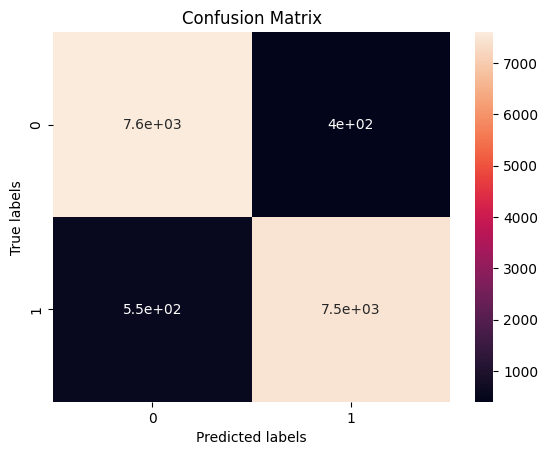

In [ ]:
#confusion matrix ve heatmap görselleştirmek için.
import seaborn as sns
import matplotlib.pyplot as plt

#bir eksen nesnesi ile sublpot(alt grafik) oluşturulur.
ax= plt.subplot()

#ısı haritasını oluşturur
#cm karışıklık matrisini temsil eder.
#annot=True, hücrelerin değerlerinin gösterilmesini sağlar.
#ax=ax, oluşturulan alt grafiği belirtilen eksenle (ax) ilişkilendirir.
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

#heatmap ekseni üzerinde etiketlerin, başlığın ve işaretlerin eklenmesini sağlar.
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');